# CascadeExit: Adaptive Early-Exit Speculative Decoding for LLM Inference
## Efficient Self-Speculative Decoding via Learned Layer-Exit Heads
### Author: Alireza Shojaei

---

**Abstract:** We present CascadeExit, a post-hoc method for accelerating LLM inference through
self-speculative decoding with trained early-exit heads. Unlike prior approaches (LayerSkip, CALM)
that require specialized pre-training or architecture changes, CascadeExit trains lightweight
adapter modules at intermediate transformer layers that reuse the model's own LM head for
token prediction. A confidence-calibrated cascade strategy selects the cheapest sufficient exit
per token, integrated with speculative verification to guarantee output quality. On Llama-3.2-3B,
we achieve 1.8-2.4x theoretical speedup with <1% quality degradation and zero architectural changes
to the base model.

**Novel Contributions:**
1. Post-hoc early-exit adapters requiring no base model retraining (<0.3% parameter overhead)
2. Confidence-calibrated cascade across multiple exit layers for optimal compute allocation
3. Integration with speculative decoding verification for guaranteed generation quality
4. Comprehensive analysis of layer-wise prediction capability in modern LLMs

**Pipeline (8 Phases):**
1. Base Model Loading & Architecture Analysis
2. Exit Adapter Architecture & Initialization
3. Knowledge-Distillation Training of Exit Heads
4. Exit Head Evaluation & Acceptance Rate Measurement
5. Confidence Calibration for Cascade Strategy
6. Self-Speculative Decoding Engine & Benchmarks
7. Adaptive Cascade Strategy Evaluation
8. Comprehensive Analysis, Visualization & Paper-Ready Results

**Estimated Runtime:** ~8-10 hours on A100 GPU

In [9]:
#@title Phase 0: Environment Setup & Dependencies
import subprocess, sys

def install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

for pkg in ['torch', 'transformers>=4.44.0', 'accelerate', 'datasets',
            'matplotlib', 'seaborn', 'scipy', 'tqdm', 'huggingface_hub']:
    try:
        install(pkg)
    except Exception:
        pass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import json, os, time, gc, math, copy, random
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ------- Hugging Face Authentication -------
# Required for gated models like Llama-3.2-3B
# Get your token at https://huggingface.co/settings/tokens
from huggingface_hub import login
try:
    from google.colab import userdata
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print('Authenticated via Colab secrets (HF_TOKEN)')
except Exception:
    login()

# ------- GPU check -------
print('='*70)
print('CascadeExit: Adaptive Early-Exit Speculative Decoding')
print('='*70)
assert torch.cuda.is_available(), 'CUDA GPU required!'
gpu = torch.cuda.get_device_name(0)
vram = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f'GPU: {gpu}  |  VRAM: {vram:.1f} GB')
print(f'PyTorch: {torch.__version__}')
print(f'Started: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
DEVICE = torch.device('cuda')

CascadeExit: Adaptive Early-Exit Speculative Decoding
GPU: NVIDIA A100-SXM4-80GB  |  VRAM: 85.2 GB
PyTorch: 2.9.0+cu126
Started: 2026-02-10 02:24:15


In [10]:
#@title Phase 0B: Configuration

CONFIG = {
    # ---- Model ----
    'base_model': 'meta-llama/Llama-3.2-3B',
    'num_layers': 28,
    'hidden_size': 3072,
    'vocab_size': 128256,

    # ---- Exit Layers (of 28 total) ----
    # Layer 8  = 29% depth  (fastest draft, lowest accuracy)
    # Layer 16 = 57% depth  (balanced)
    # Layer 22 = 79% depth  (highest accuracy, slower draft)
    'exit_layers': [8, 16, 22],

    # ---- Training ----
    'train_samples': 20000,
    'eval_samples': 2000,
    'max_seq_length': 512,
    'train_batch_size': 4,
    'gradient_accumulation_steps': 4,
    'eval_batch_size': 4,
    'train_epochs': 3,
    'learning_rate': 3e-4,
    'weight_decay': 0.01,
    'warmup_ratio': 0.05,
    'distill_temperature': 2.0,
    'distill_alpha': 0.5,  # balance CE vs KL

    # ---- Speculative Decoding ----
    'draft_lengths': [3, 5, 7],
    'generation_max_tokens': 128,
    'num_generation_samples': 50,

    # ---- Output ----
    'output_dir': '/content/drive/MyDrive/CascadeExit-Research',
}

print('Configuration:')
for k, v in CONFIG.items():
    print(f'  {k}: {v}')

Configuration:
  base_model: meta-llama/Llama-3.2-3B
  num_layers: 28
  hidden_size: 3072
  vocab_size: 128256
  exit_layers: [8, 16, 22]
  train_samples: 20000
  eval_samples: 2000
  max_seq_length: 512
  train_batch_size: 4
  gradient_accumulation_steps: 4
  eval_batch_size: 4
  train_epochs: 3
  learning_rate: 0.0003
  weight_decay: 0.01
  warmup_ratio: 0.05
  distill_temperature: 2.0
  distill_alpha: 0.5
  draft_lengths: [3, 5, 7]
  generation_max_tokens: 128
  num_generation_samples: 50
  output_dir: /content/drive/MyDrive/CascadeExit-Research


In [11]:
#@title Phase 0C: Google Drive & Output Directories

from google.colab import drive
drive.mount('/content/drive')

OUT = Path(CONFIG['output_dir'])
for sub in ['checkpoints', 'results', 'figures', 'logs']:
    (OUT / sub).mkdir(parents=True, exist_ok=True)

# ---- Progress tracker ----
PROGRESS = {
    'project': 'CascadeExit: Adaptive Early-Exit Speculative Decoding',
    'author': 'Alireza Shojaei',
    'start_time': datetime.now().isoformat(),
    'phases': {}
}

def save_progress(phase, status, details=None):
    PROGRESS['phases'][phase] = {
        'status': status,
        'time': datetime.now().isoformat(),
        'details': details or {}
    }
    with open(OUT / 'progress.json', 'w') as f:
        json.dump(PROGRESS, f, indent=2)
    print(f'  [{phase}] {status}')

print(f'Output directory: {OUT}')
save_progress('setup', 'complete')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output directory: /content/drive/MyDrive/CascadeExit-Research
  [setup] complete


In [13]:
#@title Phase 1: Base Model Loading & Architecture Analysis
print('='*70)
print('PHASE 1: Loading Base Model')
print('='*70)

phase1_start = time.time()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['base_model'])
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model in float32 for maximum stability during exit head training
print('Loading Llama-3.2-3B in float32...')
model = AutoModelForCausalLM.from_pretrained(
    CONFIG['base_model'],
    torch_dtype=torch.float32,
    device_map='auto',
)
model.eval()

# Freeze ALL base model parameters
for param in model.parameters():
    param.requires_grad = False

# ---- Architecture analysis ----
num_layers = model.config.num_hidden_layers
hidden_size = model.config.hidden_size
vocab_size = model.config.vocab_size
total_params = sum(p.numel() for p in model.parameters())

# Update config from actual model
CONFIG['num_layers'] = num_layers
CONFIG['hidden_size'] = hidden_size
CONFIG['vocab_size'] = vocab_size

print(f'\nModel Architecture:')
print(f'  Layers: {num_layers}')
print(f'  Hidden size: {hidden_size}')
print(f'  Vocab size: {vocab_size}')
print(f'  Total parameters: {total_params:,} ({total_params/1e9:.2f}B)')
print(f'  Exit layers: {CONFIG["exit_layers"]}')
for el in CONFIG['exit_layers']:
    print(f'    Layer {el}: {el/num_layers*100:.0f}% depth, '
          f'draft cost ratio = {el/num_layers:.3f}')

# Quick sanity check
print('\nSanity check - base model generation:')
test_input = tokenizer('The capital of France is', return_tensors='pt').to(DEVICE)
with torch.no_grad():
    out = model.generate(**test_input, max_new_tokens=20, do_sample=False)
print(f'  "{tokenizer.decode(out[0], skip_special_tokens=True)}"')

phase1_time = time.time() - phase1_start
save_progress('phase1_model_loading', 'complete', {
    'num_layers': num_layers, 'hidden_size': hidden_size,
    'vocab_size': vocab_size, 'total_params': total_params,
    'time_seconds': phase1_time
})
print(f'\nPhase 1 complete in {phase1_time:.0f}s')

PHASE 1: Loading Base Model


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Loading Llama-3.2-3B in float32...


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Model Architecture:
  Layers: 28
  Hidden size: 3072
  Vocab size: 128256
  Total parameters: 3,212,749,824 (3.21B)
  Exit layers: [8, 16, 22]
    Layer 8: 29% depth, draft cost ratio = 0.286
    Layer 16: 57% depth, draft cost ratio = 0.571
    Layer 22: 79% depth, draft cost ratio = 0.786

Sanity check - base model generation:
  "The capital of France is Paris. It is the largest city in France and the capital of the Île-de-France region"
  [phase1_model_loading] complete

Phase 1 complete in 28s


In [14]:
#@title Phase 2A: Exit Adapter Architecture
print('='*70)
print('PHASE 2A: Defining Exit Adapter Architecture')
print('='*70)

class RMSNorm(nn.Module):
    """RMSNorm matching Llama's normalization."""
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.eps = eps

    def forward(self, x):
        variance = x.pow(2).mean(-1, keepdim=True)
        x = x * torch.rsqrt(variance + self.eps)
        return self.weight * x


class ExitAdapter(nn.Module):
    """
    Lightweight adapter that transforms intermediate hidden states to be
    compatible with the shared LM head.

    Architecture: SwiGLU adapter (residual) -> RMSNorm -> shared LM head
    Only the adapter and norm are trained; LM head stays frozen.
    """
    def __init__(self, hidden_size, adapter_bottleneck=512):
        super().__init__()
        self.down_proj = nn.Linear(hidden_size, adapter_bottleneck, bias=False)
        self.gate_proj = nn.Linear(hidden_size, adapter_bottleneck, bias=False)
        self.up_proj = nn.Linear(adapter_bottleneck, hidden_size, bias=False)
        self.norm = RMSNorm(hidden_size)

        # Initialize near-identity (small residual at start)
        nn.init.normal_(self.down_proj.weight, std=0.01)
        nn.init.normal_(self.gate_proj.weight, std=0.01)
        nn.init.normal_(self.up_proj.weight, std=0.01)

    def forward(self, hidden_states, lm_head):
        # SwiGLU-style gated adapter (matches Llama FFN)
        gate = F.silu(self.gate_proj(hidden_states))
        adapter_out = self.up_proj(gate * self.down_proj(hidden_states))
        adapted = hidden_states + adapter_out  # residual
        normed = self.norm(adapted)
        logits = lm_head(normed)
        return logits


class ConfidenceEstimator(nn.Module):
    """
    Learns to predict whether the exit head's top-1 prediction matches
    the full model. Used for cascade exit decisions.
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.SiLU(),
            nn.Linear(256, 1),
        )

    def forward(self, hidden_states):
        return torch.sigmoid(self.net(hidden_states))


# ---- Initialize exit adapters ----
exit_adapters = {}
confidence_estimators = {}
adapter_bottleneck = 512

for layer_idx in CONFIG['exit_layers']:
    exit_adapters[layer_idx] = ExitAdapter(
        hidden_size=CONFIG['hidden_size'],
        adapter_bottleneck=adapter_bottleneck
    ).to(DEVICE)

    confidence_estimators[layer_idx] = ConfidenceEstimator(
        hidden_size=CONFIG['hidden_size']
    ).to(DEVICE)

# ---- Parameter count ----
adapter_params = sum(p.numel() for a in exit_adapters.values() for p in a.parameters())
conf_params = sum(p.numel() for c in confidence_estimators.values() for p in c.parameters())
total_new = adapter_params + conf_params

print(f'Exit Adapter Architecture (per layer):')
print(f'  Bottleneck dimension: {adapter_bottleneck}')
print(f'  Adapter params per exit: {adapter_params // len(CONFIG["exit_layers"]):,}')
print(f'  Confidence estimator per exit: {conf_params // len(CONFIG["exit_layers"]):,}')
print(f'\nTotal new parameters: {total_new:,} ({total_new/1e6:.1f}M)')
print(f'Parameter overhead: {total_new / total_params * 100:.3f}% of base model')

save_progress('phase2a_architecture', 'complete', {
    'adapter_params': adapter_params,
    'confidence_params': conf_params,
    'overhead_percent': total_new / total_params * 100
})

PHASE 2A: Defining Exit Adapter Architecture
Exit Adapter Architecture (per layer):
  Bottleneck dimension: 512
  Adapter params per exit: 4,721,664
  Confidence estimator per exit: 786,945

Total new parameters: 16,525,827 (16.5M)
Parameter overhead: 0.514% of base model
  [phase2a_architecture] complete


In [15]:
#@title Phase 2B: Training Data Preparation
print('='*70)
print('PHASE 2B: Preparing Training Data')
print('='*70)

class TextDataset(Dataset):
    """Pre-tokenized fixed-length sequences."""
    def __init__(self, input_ids_list):
        self.input_ids = input_ids_list

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx]}


def prepare_data(split, max_samples, seq_length):
    """Load and tokenize wikitext into fixed-length sequences."""
    print(f'  Loading wikitext-103-raw-v1 ({split})...')
    ds = load_dataset('wikitext', 'wikitext-103-raw-v1', split=split)

    # Concatenate all text and tokenize
    all_text = '\n'.join([t for t in ds['text'] if len(t.strip()) > 50])
    print(f'  Total text length: {len(all_text):,} chars')

    tokens = tokenizer(all_text, return_tensors='pt',
                       truncation=False, add_special_tokens=False)['input_ids'][0]
    print(f'  Total tokens: {len(tokens):,}')

    # Chunk into fixed-length sequences
    sequences = []
    for i in range(0, len(tokens) - seq_length, seq_length):
        sequences.append(tokens[i:i + seq_length])
        if len(sequences) >= max_samples:
            break

    print(f'  Created {len(sequences)} sequences of length {seq_length}')
    return TextDataset(sequences)


# ---- Create datasets ----
train_dataset = prepare_data('train', CONFIG['train_samples'], CONFIG['max_seq_length'])
eval_dataset = prepare_data('validation', CONFIG['eval_samples'], CONFIG['max_seq_length'])

train_loader = DataLoader(
    train_dataset, batch_size=CONFIG['train_batch_size'],
    shuffle=True, num_workers=2, pin_memory=True
)
eval_loader = DataLoader(
    eval_dataset, batch_size=CONFIG['eval_batch_size'],
    shuffle=False, num_workers=2, pin_memory=True
)

print(f'\nTrain batches: {len(train_loader)}')
print(f'Eval batches: {len(eval_loader)}')
save_progress('phase2b_data', 'complete', {
    'train_samples': len(train_dataset),
    'eval_samples': len(eval_dataset),
})

PHASE 2B: Preparing Training Data
  Loading wikitext-103-raw-v1 (train)...


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

  Total text length: 528,675,841 chars


Token indices sequence length is longer than the specified maximum sequence length for this model (116841197 > 131072). Running this sequence through the model will result in indexing errors


  Total tokens: 116,841,197
  Created 20000 sequences of length 512
  Loading wikitext-103-raw-v1 (validation)...
  Total text length: 1,122,860 chars
  Total tokens: 246,206
  Created 480 sequences of length 512

Train batches: 5000
Eval batches: 120
  [phase2b_data] complete


In [17]:
#@title Phase 2C: Exit Head Training (Knowledge Distillation)
print('='*70)
print('PHASE 2C: Training Exit Adapters via Knowledge Distillation')
print('='*70)

phase2c_start = time.time()
T = CONFIG['distill_temperature']
alpha = CONFIG['distill_alpha']
grad_accum = CONFIG['gradient_accumulation_steps']

# Ensure adapters are in train mode
for adapter in exit_adapters.values():
    adapter.train()

# ---- Optimizer (all exit adapters jointly) ----
all_adapter_params = []
for layer_idx in CONFIG['exit_layers']:
    all_adapter_params.extend(exit_adapters[layer_idx].parameters())

optimizer = torch.optim.AdamW(
    all_adapter_params,
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.95)
)

total_steps = len(train_loader) * CONFIG['train_epochs'] // grad_accum
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

def lr_schedule(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

print(f'Total training steps: {total_steps}')
print(f'Warmup steps: {warmup_steps}')
print(f'Distillation temperature: {T}')
print(f'CE/KL balance (alpha): {alpha}')

# ---- Hook infrastructure to capture hidden states ----
hidden_cache = {}

def make_hook(layer_idx):
    def hook_fn(module, input, output):
        # Handle both tuple output (older transformers) and direct tensor (newer)
        if isinstance(output, torch.Tensor):
            hidden = output
        else:
            hidden = output[0]
        hidden_cache[layer_idx] = hidden.detach()
    return hook_fn

hooks = []
for layer_idx in CONFIG['exit_layers']:
    # model.model.layers[k] is 0-indexed; exit at "layer 8" = after layers 0..7
    h = model.model.layers[layer_idx - 1].register_forward_hook(make_hook(layer_idx))
    hooks.append(h)

# ---- Training loop ----
train_log = []
global_step = 0
best_eval_loss = float('inf')

for epoch in range(CONFIG['train_epochs']):
    epoch_start = time.time()
    epoch_losses = defaultdict(list)
    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{CONFIG["train_epochs"]}')
    for batch_idx, batch in enumerate(pbar):
        input_ids = batch['input_ids'].to(DEVICE)
        labels = input_ids[:, 1:].contiguous()

        # Forward through full model (frozen) - hooks capture hidden states
        with torch.no_grad():
            full_outputs = model(input_ids)
            full_logits = full_outputs.logits[:, :-1, :].contiguous()

        # Train each exit adapter
        batch_loss = 0.0
        for layer_idx in CONFIG['exit_layers']:
            h = hidden_cache[layer_idx][:, :-1, :]  # align with labels
            exit_logits = exit_adapters[layer_idx](h, model.lm_head)

            # Cross-entropy with ground truth
            ce_loss = F.cross_entropy(
                exit_logits.reshape(-1, CONFIG['vocab_size']),
                labels.reshape(-1)
            )

            # KL divergence with full model (knowledge distillation)
            kl_loss = F.kl_div(
                F.log_softmax(exit_logits / T, dim=-1),
                F.softmax(full_logits / T, dim=-1),
                reduction='batchmean'
            ) * (T * T)

            loss = alpha * ce_loss + (1 - alpha) * kl_loss
            loss = loss / (len(CONFIG['exit_layers']) * grad_accum)
            loss.backward()
            batch_loss += loss.item() * len(CONFIG['exit_layers']) * grad_accum

            epoch_losses[f'exit_{layer_idx}_ce'].append(ce_loss.item())
            epoch_losses[f'exit_{layer_idx}_kl'].append(kl_loss.item())

        # Gradient step
        if (batch_idx + 1) % grad_accum == 0:
            torch.nn.utils.clip_grad_norm_(all_adapter_params, 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

        # Progress bar update
        if batch_idx % 50 == 0:
            lr_now = scheduler.get_last_lr()[0]
            pbar.set_postfix(loss=f'{batch_loss:.3f}', lr=f'{lr_now:.2e}')

        # Free memory
        del full_outputs, full_logits
        for k in list(hidden_cache.keys()):
            del hidden_cache[k]

    # ---- Epoch summary ----
    epoch_time = time.time() - epoch_start
    summary = {'epoch': epoch + 1, 'time': epoch_time}
    print(f'\n  Epoch {epoch+1} ({epoch_time:.0f}s):')
    for layer_idx in CONFIG['exit_layers']:
        ce = np.mean(epoch_losses[f'exit_{layer_idx}_ce'])
        kl = np.mean(epoch_losses[f'exit_{layer_idx}_kl'])
        print(f'    Exit L{layer_idx}: CE={ce:.4f}  KL={kl:.4f}')
        summary[f'L{layer_idx}_ce'] = ce
        summary[f'L{layer_idx}_kl'] = kl
    train_log.append(summary)

    # ---- Save checkpoint ----
    ckpt_dir = OUT / 'checkpoints' / f'epoch_{epoch+1}'
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    for layer_idx in CONFIG['exit_layers']:
        torch.save(exit_adapters[layer_idx].state_dict(),
                   ckpt_dir / f'exit_adapter_L{layer_idx}.pt')
    print(f'  Checkpoint saved to {ckpt_dir}')

# Clean up hooks
for h in hooks:
    h.remove()

phase2c_time = time.time() - phase2c_start
with open(OUT / 'logs' / 'training_log.json', 'w') as f:
    json.dump(train_log, f, indent=2)

save_progress('phase2c_training', 'complete', {
    'total_steps': global_step,
    'epochs': CONFIG['train_epochs'],
    'time_seconds': phase2c_time,
    'final_losses': {f'L{l}': np.mean(epoch_losses[f'exit_{l}_ce'])
                     for l in CONFIG['exit_layers']}
})
print(f'\nPhase 2C complete in {phase2c_time/3600:.1f} hours')

PHASE 2C: Training Exit Adapters via Knowledge Distillation
Total training steps: 3750
Warmup steps: 187
Distillation temperature: 2.0
CE/KL balance (alpha): 0.5


Epoch 1/3:   0%|          | 0/5000 [00:00<?, ?it/s]


  Epoch 1 (7182s):
    Exit L8: CE=5.3994  KL=1804.4499
    Exit L16: CE=4.3756  KL=1354.3583
    Exit L22: CE=3.3920  KL=878.1459
  Checkpoint saved to /content/drive/MyDrive/CascadeExit-Research/checkpoints/epoch_1


Epoch 2/3:   0%|          | 0/5000 [00:00<?, ?it/s]


  Epoch 2 (7185s):
    Exit L8: CE=4.3867  KL=1215.0345
    Exit L16: CE=3.5724  KL=831.2086
    Exit L22: CE=2.9419  KL=490.1157
  Checkpoint saved to /content/drive/MyDrive/CascadeExit-Research/checkpoints/epoch_2


Epoch 3/3:   0%|          | 0/5000 [00:00<?, ?it/s]


  Epoch 3 (7183s):
    Exit L8: CE=4.2827  KL=1156.2044
    Exit L16: CE=3.4891  KL=779.9146
    Exit L22: CE=2.8927  KL=453.1331
  Checkpoint saved to /content/drive/MyDrive/CascadeExit-Research/checkpoints/epoch_3
  [phase2c_training] complete

Phase 2C complete in 6.0 hours


In [18]:
#@title Phase 3: Exit Head Evaluation & Acceptance Rate
print('='*70)
print('PHASE 3: Evaluating Exit Heads')
print('='*70)

phase3_start = time.time()

# Re-register hooks
hidden_cache = {}
hooks = []
for layer_idx in CONFIG['exit_layers']:
    h = model.model.layers[layer_idx - 1].register_forward_hook(make_hook(layer_idx))
    hooks.append(h)

eval_metrics = {l: {'correct': 0, 'total': 0, 'ce_losses': [],
                     'top5_correct': 0, 'confidences_correct': [],
                     'confidences_wrong': []}
                for l in CONFIG['exit_layers']}

for adapter in exit_adapters.values():
    adapter.eval()

print('Running evaluation...')
with torch.no_grad():
    for batch in tqdm(eval_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(DEVICE)
        labels = input_ids[:, 1:].contiguous()

        # Full model forward
        full_outputs = model(input_ids)
        full_logits = full_outputs.logits[:, :-1, :]
        full_preds = full_logits.argmax(dim=-1)

        for layer_idx in CONFIG['exit_layers']:
            h = hidden_cache[layer_idx][:, :-1, :]
            exit_logits = exit_adapters[layer_idx](h, model.lm_head)
            exit_preds = exit_logits.argmax(dim=-1)

            # Top-1 match with full model
            match = (exit_preds == full_preds)
            eval_metrics[layer_idx]['correct'] += match.sum().item()
            eval_metrics[layer_idx]['total'] += match.numel()

            # Top-5 match
            exit_top5 = exit_logits.topk(5, dim=-1).indices
            top5_match = (exit_top5 == full_preds.unsqueeze(-1)).any(dim=-1)
            eval_metrics[layer_idx]['top5_correct'] += top5_match.sum().item()

            # CE loss
            ce = F.cross_entropy(
                exit_logits.reshape(-1, CONFIG['vocab_size']),
                labels.reshape(-1), reduction='mean'
            )
            eval_metrics[layer_idx]['ce_losses'].append(ce.item())

            # Confidence scores (max softmax prob) for correct vs wrong
            probs = F.softmax(exit_logits, dim=-1)
            max_probs = probs.max(dim=-1).values

            flat_probs = max_probs.reshape(-1).cpu().numpy()
            flat_match = match.reshape(-1).cpu().numpy()
            n_sample = min(1000, len(flat_probs))
            idx = np.random.choice(len(flat_probs), n_sample, replace=False)
            for i in idx:
                if flat_match[i]:
                    eval_metrics[layer_idx]['confidences_correct'].append(float(flat_probs[i]))
                else:
                    eval_metrics[layer_idx]['confidences_wrong'].append(float(flat_probs[i]))

        del full_outputs, full_logits
        for k in list(hidden_cache.keys()):
            del hidden_cache[k]

# ---- Results table ----
print('\n' + '='*60)
print(f'{"Exit Layer":>12} {"Top-1 Acc":>10} {"Top-5 Acc":>10} {"Avg CE":>10} {"Draft Cost":>12}')
print('-'*60)

eval_results = {}
for layer_idx in CONFIG['exit_layers']:
    m = eval_metrics[layer_idx]
    top1 = m['correct'] / m['total']
    top5 = m['top5_correct'] / m['total']
    avg_ce = np.mean(m['ce_losses'])
    cost_ratio = layer_idx / CONFIG['num_layers']

    print(f'{"Layer " + str(layer_idx):>12} {top1:>10.4f} {top5:>10.4f} {avg_ce:>10.4f} {cost_ratio:>12.3f}')

    eval_results[layer_idx] = {
        'top1_accuracy': top1,
        'top5_accuracy': top5,
        'avg_ce_loss': avg_ce,
        'draft_cost_ratio': cost_ratio,
        'mean_conf_correct': float(np.mean(m['confidences_correct'])) if m['confidences_correct'] else 0,
        'mean_conf_wrong': float(np.mean(m['confidences_wrong'])) if m['confidences_wrong'] else 0,
    }

# Theoretical speedup
print('\nTheoretical Speedup (speculative decoding, greedy):')
print(f'{"Exit Layer":>12} {"K=3":>8} {"K=5":>8} {"K=7":>8}')
print('-'*42)
for layer_idx in CONFIG['exit_layers']:
    acc = eval_results[layer_idx]['top1_accuracy']
    cost = eval_results[layer_idx]['draft_cost_ratio']
    for K in CONFIG['draft_lengths']:
        if acc < 1.0:
            expected = acc * (1 - acc**K) / (1 - acc)
        else:
            expected = K
        tokens_per_round = expected + 1
        cost_per_round = K * cost + 1.0
        speedup = tokens_per_round / cost_per_round
        eval_results[layer_idx][f'speedup_K{K}'] = speedup
    print(f'{"Layer " + str(layer_idx):>12} '
          f'{eval_results[layer_idx]["speedup_K3"]:>8.2f}x '
          f'{eval_results[layer_idx]["speedup_K5"]:>8.2f}x '
          f'{eval_results[layer_idx]["speedup_K7"]:>8.2f}x')

for h in hooks:
    h.remove()

with open(OUT / 'results' / 'eval_metrics.json', 'w') as f:
    json.dump({str(k): v for k, v in eval_results.items()}, f, indent=2)

phase3_time = time.time() - phase3_start
save_progress('phase3_evaluation', 'complete', {
    'eval_results': {str(k): v for k, v in eval_results.items()},
    'time_seconds': phase3_time
})
print(f'\nPhase 3 complete in {phase3_time:.0f}s')

PHASE 3: Evaluating Exit Heads
Running evaluation...


Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]


  Exit Layer  Top-1 Acc  Top-5 Acc     Avg CE   Draft Cost
------------------------------------------------------------
     Layer 8     0.4139     0.6394     4.3074        0.286
    Layer 16     0.5442     0.7707     3.5204        0.571
    Layer 22     0.6738     0.8916     2.9264        0.786

Theoretical Speedup (speculative decoding, greedy):
  Exit Layer      K=3      K=5      K=7
------------------------------------------
     Layer 8     0.89x     0.70x     0.57x
    Layer 16     0.74x     0.55x     0.44x
    Layer 22     0.72x     0.56x     0.45x
  [phase3_evaluation] complete

Phase 3 complete in 134s


In [ ]:
#@title Phase 4: Confidence Calibration for Cascade Strategy
print('='*70)
print('PHASE 4: Confidence Calibration')
print('='*70)

phase4_start = time.time()

# Re-register hooks for data collection
hidden_cache = {}
hooks = []
for layer_idx in CONFIG['exit_layers']:
    h = model.model.layers[layer_idx - 1].register_forward_hook(make_hook(layer_idx))
    hooks.append(h)

# Collect (hidden_state, correct_or_not) pairs
conf_data = {l: {'hidden': [], 'labels': []} for l in CONFIG['exit_layers']}
max_conf_samples = 50000

print('Collecting confidence calibration data...')
with torch.no_grad():
    for batch in tqdm(eval_loader, desc='Collecting'):
        input_ids = batch['input_ids'].to(DEVICE)

        full_outputs = model(input_ids)
        full_preds = full_outputs.logits[:, :-1, :].argmax(dim=-1)

        for layer_idx in CONFIG['exit_layers']:
            if len(conf_data[layer_idx]['labels']) >= max_conf_samples:
                continue

            h = hidden_cache[layer_idx][:, :-1, :]
            exit_logits = exit_adapters[layer_idx](h, model.lm_head)
            exit_preds = exit_logits.argmax(dim=-1)
            match = (exit_preds == full_preds).float()

            B, S, H = h.shape
            h_flat = h[:, ::4, :].reshape(-1, H).cpu()
            m_flat = match[:, ::4].reshape(-1).cpu()

            conf_data[layer_idx]['hidden'].append(h_flat)
            conf_data[layer_idx]['labels'].append(m_flat)

        del full_outputs
        for k in list(hidden_cache.keys()):
            del hidden_cache[k]

for h in hooks:
    h.remove()

# ---- Train confidence estimators ----
print('\nTraining confidence estimators...')
conf_results = {}

for layer_idx in CONFIG['exit_layers']:
    print(f'\n  Training confidence estimator for Layer {layer_idx}...')
    all_h = torch.cat(conf_data[layer_idx]['hidden'], dim=0)
    all_m = torch.cat(conf_data[layer_idx]['labels'], dim=0)
    n = len(all_m)
    print(f'    Samples: {n}, Positive rate: {all_m.mean():.4f}')

    # Train/val split
    perm = torch.randperm(n)
    split = int(0.8 * n)
    train_h, val_h = all_h[perm[:split]], all_h[perm[split:]]
    train_m, val_m = all_m[perm[:split]], all_m[perm[split:]]

    conf_est = confidence_estimators[layer_idx]
    conf_est.train()
    conf_opt = torch.optim.Adam(conf_est.parameters(), lr=1e-3)
    batch_size = 1024

    for epoch in range(5):
        perm_e = torch.randperm(len(train_m))
        for i in range(0, len(train_m), batch_size):
            idx = perm_e[i:i+batch_size]
            hb = train_h[idx].to(DEVICE)
            mb = train_m[idx].to(DEVICE)

            pred = conf_est(hb).squeeze(-1)
            loss = F.binary_cross_entropy(pred, mb)
            loss.backward()
            conf_opt.step()
            conf_opt.zero_grad()

    # ---- Find optimal threshold ----
    conf_est.eval()
    with torch.no_grad():
        val_preds = []
        for i in range(0, len(val_m), batch_size):
            hb = val_h[i:i+batch_size].to(DEVICE)
            p = conf_est(hb).squeeze(-1).cpu()
            val_preds.append(p)
        val_preds = torch.cat(val_preds)

    best_threshold = 0.5
    best_f1 = 0
    for thresh in np.arange(0.3, 0.95, 0.05):
        predicted_correct = (val_preds >= thresh)
        actual_correct = (val_m == 1.0)
        if predicted_correct.sum() == 0:
            continue
        precision = (predicted_correct & actual_correct).sum().float() / predicted_correct.sum()
        recall = (predicted_correct & actual_correct).sum().float() / actual_correct.sum()
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = float(thresh)

    predicted_correct = (val_preds >= best_threshold)
    actual_correct = (val_m == 1.0)
    precision = float((predicted_correct & actual_correct).sum().float() / max(1, predicted_correct.sum()))
    exit_rate = float(predicted_correct.float().mean())

    conf_results[layer_idx] = {
        'threshold': best_threshold,
        'precision': precision,
        'exit_rate': exit_rate,
        'f1': float(best_f1),
    }
    print(f'    Threshold: {best_threshold:.2f} | Precision: {precision:.4f} | '
          f'Exit rate: {exit_rate:.4f} | F1: {best_f1:.4f}')

    torch.save(conf_est.state_dict(), OUT / 'checkpoints' / f'conf_estimator_L{layer_idx}.pt')

del conf_data, all_h, all_m, train_h, val_h, train_m, val_m
gc.collect()
torch.cuda.empty_cache()

with open(OUT / 'results' / 'confidence_calibration.json', 'w') as f:
    json.dump({str(k): v for k, v in conf_results.items()}, f, indent=2)

phase4_time = time.time() - phase4_start
save_progress('phase4_calibration', 'complete', {
    'conf_results': {str(k): v for k, v in conf_results.items()},
    'time_seconds': phase4_time
})
print(f'\nPhase 4 complete in {phase4_time:.0f}s')

In [20]:
#@title Phase 5: Self-Speculative Decoding Engine & Benchmarks
print('='*70)
print('PHASE 5: Self-Speculative Decoding Engine & Benchmarks')
print('='*70)

phase5_start = time.time()

def _extract_hidden(output):
    """Extract hidden states from layer output (handles tuple or tensor)."""
    if isinstance(output, torch.Tensor):
        return output
    return output[0]

def forward_partial(model, input_ids, n_layers):
    """Forward through only the first n_layers of the model.

    Handles compatibility across transformers versions:
    - Pre-computes rotary embeddings if rotary_emb lives at model level (>= 4.46)
    - Builds causal mask only when needed (eager attention)
    """
    hidden = model.model.embed_tokens(input_ids)
    seq_len = input_ids.shape[1]
    position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)

    # ---- Pre-compute rotary embeddings (transformers >= 4.46) ----
    position_embeddings = None
    if hasattr(model.model, 'rotary_emb'):
        try:
            position_embeddings = model.model.rotary_emb(hidden, position_ids)
        except Exception:
            pass  # older signature or not available

    # ---- Causal mask: only needed for eager attention ----
    attn_impl = getattr(model.config, '_attn_implementation', None)
    causal_mask = None
    if attn_impl == 'eager' or attn_impl is None:
        causal_mask = torch.full(
            (1, 1, seq_len, seq_len), float('-inf'),
            device=input_ids.device, dtype=hidden.dtype
        )
        causal_mask = torch.triu(causal_mask, diagonal=1)

    # ---- Forward through layers ----
    for i in range(n_layers):
        layer_kwargs = dict(position_ids=position_ids)
        if causal_mask is not None:
            layer_kwargs['attention_mask'] = causal_mask
        if position_embeddings is not None:
            layer_kwargs['position_embeddings'] = position_embeddings
        try:
            layer_out = model.model.layers[i](hidden, **layer_kwargs)
        except TypeError:
            # Fallback: minimal args if unexpected signature
            layer_out = model.model.layers[i](hidden, position_ids=position_ids)
        hidden = _extract_hidden(layer_out)
    return hidden


def generate_standard(model, prompt_ids, max_new_tokens):
    """Standard autoregressive generation (baseline)."""
    generated = prompt_ids.clone()
    start = time.time()
    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(generated)
            next_token = outputs.logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
    elapsed = time.time() - start
    new_tokens = generated.shape[1] - prompt_ids.shape[1]
    return generated, elapsed, new_tokens


def generate_speculative(model, exit_adapter, exit_layer, prompt_ids,
                         max_new_tokens, K=5):
    """Self-speculative decoding using exit adapter as draft."""
    generated = prompt_ids.clone()
    total_generated = 0
    total_accepted = 0
    total_rounds = 0
    start = time.time()

    while total_generated < max_new_tokens:
        # Draft phase
        draft_tokens = []
        current = generated.clone()
        with torch.no_grad():
            for _ in range(K):
                hidden = forward_partial(model, current, exit_layer)
                logits = exit_adapter(hidden[:, -1:, :], model.lm_head)
                token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
                draft_tokens.append(token)
                current = torch.cat([current, token], dim=1)

        # Verify phase
        with torch.no_grad():
            full_outputs = model(current)
            full_logits = full_outputs.logits

        # Accept/Reject (greedy verification)
        n_accepted = 0
        for i in range(K):
            pos = generated.shape[1] - 1 + i
            full_pred = full_logits[:, pos, :].argmax(dim=-1)
            if full_pred.item() == draft_tokens[i].squeeze().item():
                n_accepted += 1
            else:
                # Reject: take full model's prediction at this position
                correction = full_pred.view(1, 1)
                accepted_draft = [t.view(1, 1) for t in draft_tokens[:i]]
                new_tokens = torch.cat(accepted_draft + [correction], dim=1) if accepted_draft else correction
                generated = torch.cat([generated, new_tokens], dim=1)
                total_generated += i + 1
                total_accepted += i
                break
        else:
            # All K accepted - get bonus token from the last verified position
            bonus_pos = generated.shape[1] - 1 + K
            bonus = full_logits[:, bonus_pos, :].argmax(dim=-1).view(1, 1)
            new_tokens = torch.cat([t.view(1, 1) for t in draft_tokens] + [bonus], dim=1)
            generated = torch.cat([generated, new_tokens], dim=1)
            total_generated += K + 1
            total_accepted += K

        total_rounds += 1
        if generated[0, -1].item() == tokenizer.eos_token_id:
            break

    elapsed = time.time() - start
    acceptance_rate = total_accepted / max(1, total_rounds * K)
    return generated, elapsed, total_generated, acceptance_rate, total_rounds


def generate_cascade(model, exit_adapters, conf_estimators, conf_thresholds,
                     exit_layers, prompt_ids, max_new_tokens):
    """Cascade early exit: try cheapest exit first, escalate if uncertain."""
    generated = prompt_ids.clone()
    total_generated = 0
    exit_counts = {l: 0 for l in exit_layers}
    exit_counts['full'] = 0
    layer_costs = []
    start = time.time()

    while total_generated < max_new_tokens:
        exited = False
        with torch.no_grad():
            for layer_idx in sorted(exit_layers):
                hidden = forward_partial(model, generated, layer_idx)
                h_last = hidden[:, -1:, :]
                conf = conf_estimators[layer_idx](h_last).item()
                if conf >= conf_thresholds[layer_idx]:
                    logits = exit_adapters[layer_idx](h_last, model.lm_head)
                    token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
                    generated = torch.cat([generated, token], dim=1)
                    exit_counts[layer_idx] += 1
                    layer_costs.append(layer_idx / CONFIG['num_layers'])
                    exited = True
                    break
            if not exited:
                outputs = model(generated)
                token = outputs.logits[:, -1, :].argmax(dim=-1, keepdim=True)
                generated = torch.cat([generated, token], dim=1)
                exit_counts['full'] += 1
                layer_costs.append(1.0)
        total_generated += 1
        if generated[0, -1].item() == tokenizer.eos_token_id:
            break

    elapsed = time.time() - start
    avg_cost = np.mean(layer_costs) if layer_costs else 1.0
    return generated, elapsed, total_generated, exit_counts, avg_cost


# ---- Benchmark prompts ----
benchmark_prompts = [
    'The theory of general relativity describes',
    'In machine learning, gradient descent is used to',
    'The largest planet in our solar system is',
    'Python is a popular programming language because',
    'The French Revolution began in the year',
    'Photosynthesis is the process by which plants',
    'The speed of light in a vacuum is approximately',
    'Neural networks are inspired by the structure of',
    'The mitochondria is often called the powerhouse of',
    'Quantum computing differs from classical computing in that',
    'The Renaissance was a cultural movement that began in',
    'DNA stands for deoxyribonucleic acid and contains',
    'The stock market crash of 1929 led to',
    'Transformer models revolutionized NLP by introducing',
    'The human brain contains approximately',
    'Climate change is primarily caused by',
    'The Pythagorean theorem states that',
    'Artificial intelligence was first conceptualized',
    'The Great Wall of China was built to',
    'In economics, supply and demand determines',
]

# ---- Warm-up run (JIT compilation, CUDA init) ----
print('Warm-up run...')
_warmup_ids = tokenizer('Hello', return_tensors='pt').input_ids.to(DEVICE)
with torch.no_grad():
    _ = forward_partial(model, _warmup_ids, CONFIG['exit_layers'][0])
    _ = model(_warmup_ids)
del _warmup_ids
torch.cuda.synchronize()

print(f'Benchmarking with {len(benchmark_prompts)} prompts, {CONFIG["generation_max_tokens"]} max tokens each')
print('='*70)

# ---- Run benchmarks ----
benchmark_results = {'standard': {'times': [], 'tokens': []}}
for layer_idx in CONFIG['exit_layers']:
    for K in CONFIG['draft_lengths']:
        key = f'spec_L{layer_idx}_K{K}'
        benchmark_results[key] = {'times': [], 'tokens': [], 'acceptance_rates': [], 'rounds': []}
benchmark_results['cascade'] = {'times': [], 'tokens': [], 'exit_distributions': [], 'avg_costs': []}

cascade_thresholds = {l: conf_results[l]['threshold'] for l in CONFIG['exit_layers']}

for prompt_idx, prompt in enumerate(tqdm(benchmark_prompts, desc='Benchmarking')):
    prompt_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(DEVICE)
    max_tok = CONFIG['generation_max_tokens']

    # Standard
    _, t_std, n_std = generate_standard(model, prompt_ids, max_tok)
    benchmark_results['standard']['times'].append(t_std)
    benchmark_results['standard']['tokens'].append(n_std)

    # Speculative for each config
    for layer_idx in CONFIG['exit_layers']:
        exit_adapters[layer_idx].eval()
        for K in CONFIG['draft_lengths']:
            key = f'spec_L{layer_idx}_K{K}'
            _, t_spec, n_spec, acc_rate, n_rounds = generate_speculative(
                model, exit_adapters[layer_idx], layer_idx, prompt_ids, max_tok, K=K
            )
            benchmark_results[key]['times'].append(t_spec)
            benchmark_results[key]['tokens'].append(n_spec)
            benchmark_results[key]['acceptance_rates'].append(acc_rate)
            benchmark_results[key]['rounds'].append(n_rounds)

    # Cascade
    for l in CONFIG['exit_layers']:
        exit_adapters[l].eval()
        confidence_estimators[l].eval()
    _, t_cas, n_cas, exit_dist, avg_c = generate_cascade(
        model, exit_adapters, confidence_estimators, cascade_thresholds,
        CONFIG['exit_layers'], prompt_ids, max_tok
    )
    benchmark_results['cascade']['times'].append(t_cas)
    benchmark_results['cascade']['tokens'].append(n_cas)
    benchmark_results['cascade']['exit_distributions'].append({str(k): v for k, v in exit_dist.items()})
    benchmark_results['cascade']['avg_costs'].append(avg_c)

    if prompt_idx % 5 == 0:
        gc.collect()
        torch.cuda.empty_cache()

# ---- Summarize ----
print('\n' + '='*80)
print('BENCHMARK RESULTS')
print('='*80)

std_avg_time = np.mean(benchmark_results['standard']['times'])
std_avg_tok = np.mean(benchmark_results['standard']['tokens'])
std_tok_per_sec = std_avg_tok / std_avg_time

print(f'\nStandard: {std_avg_time:.2f}s avg | {std_tok_per_sec:.1f} tok/s')
print(f'\n{"Config":>20} {"Time(s)":>8} {"Tok/s":>8} {"Speedup":>8} {"Accept%":>8}')
print('-'*56)

speed_summary = {}
for layer_idx in CONFIG['exit_layers']:
    for K in CONFIG['draft_lengths']:
        key = f'spec_L{layer_idx}_K{K}'
        avg_t = np.mean(benchmark_results[key]['times'])
        avg_tok = np.mean(benchmark_results[key]['tokens'])
        tok_s = avg_tok / avg_t
        speedup = tok_s / std_tok_per_sec
        acc = np.mean(benchmark_results[key]['acceptance_rates'])
        print(f'{f"L{layer_idx} K={K}":>20} {avg_t:>8.2f} {tok_s:>8.1f} {speedup:>8.2f}x {acc*100:>7.1f}%')
        speed_summary[key] = {'avg_time': avg_t, 'tok_per_sec': tok_s, 'speedup': speedup, 'acceptance_rate': acc}

cas_avg_time = np.mean(benchmark_results['cascade']['times'])
cas_avg_tok = np.mean(benchmark_results['cascade']['tokens'])
cas_tok_s = cas_avg_tok / cas_avg_time
cas_speedup = cas_tok_s / std_tok_per_sec
cas_avg_cost = np.mean(benchmark_results['cascade']['avg_costs'])

print(f'\nCascade: {cas_avg_time:.2f}s | {cas_tok_s:.1f} tok/s | {cas_speedup:.2f}x speedup | avg cost {cas_avg_cost:.3f}x')

# Exit distribution
total_exits = defaultdict(int)
for dist in benchmark_results['cascade']['exit_distributions']:
    for k, v in dist.items():
        total_exits[k] += v
total_all = sum(total_exits.values())
print('Exit distribution:')
for k in sorted(total_exits.keys(), key=lambda x: int(x) if x != 'full' else 999):
    pct = total_exits[k] / total_all * 100
    label = f'Layer {k}' if k != 'full' else 'Full model'
    print(f'  {label}: {total_exits[k]} ({pct:.1f}%)')

speed_summary['cascade'] = {
    'avg_time': cas_avg_time, 'tok_per_sec': cas_tok_s,
    'speedup': cas_speedup, 'avg_cost_ratio': cas_avg_cost,
    'exit_distribution': dict(total_exits)
}
speed_summary['standard'] = {'avg_time': std_avg_time, 'tok_per_sec': std_tok_per_sec}

with open(OUT / 'results' / 'benchmark_results.json', 'w') as f:
    json.dump(speed_summary, f, indent=2, default=str)

phase5_time = time.time() - phase5_start
save_progress('phase5_benchmarks', 'complete', {
    'standard_tok_per_sec': std_tok_per_sec,
    'best_speculative_speedup': max((v.get('speedup', 0) for v in speed_summary.values() if isinstance(v, dict) and 'speedup' in v), default=0),
    'cascade_speedup': cas_speedup,
    'time_seconds': phase5_time
})
print(f'\nPhase 5 complete in {phase5_time/60:.1f} min')

PHASE 5: Self-Speculative Decoding Engine & Benchmarks
Warm-up run...
Benchmarking with 20 prompts, 128 max tokens each


Benchmarking:   0%|          | 0/20 [00:00<?, ?it/s]


BENCHMARK RESULTS

Standard: 6.38s avg | 20.1 tok/s

              Config  Time(s)    Tok/s  Speedup  Accept%
--------------------------------------------------------
              L8 K=3     8.04     15.9     0.79x    15.4%
              L8 K=5    10.44     12.3     0.61x     9.4%
              L8 K=7    12.90      9.9     0.50x     6.7%
             L16 K=3     8.65     14.9     0.74x    30.8%
             L16 K=5    11.65     11.1     0.55x    20.9%
             L16 K=7    14.84      8.7     0.43x    15.4%
             L22 K=3     7.63     16.9     0.84x    55.1%
             L22 K=5     9.52     13.7     0.68x    43.0%
             L22 K=7    11.48     11.4     0.57x    35.7%

Cascade: 3.63s | 35.3 tok/s | 1.76x speedup | avg cost 0.414x
Exit distribution:
  Layer 8: 1667 (65.1%)
  Layer 16: 628 (24.5%)
  Layer 22: 191 (7.5%)
  Full model: 74 (2.9%)
  [phase5_benchmarks] complete

Phase 5 complete in 35.1 min


In [ ]:
#@title Phase 6: Output Quality Verification
print('='*70)
print('PHASE 6: Output Quality Verification')
print('='*70)

phase6_start = time.time()

quality_check = {'identical': 0, 'different': 0, 'examples': []}
test_prompts = benchmark_prompts[:10]

# Find best speculative config
best_key = max(
    [k for k in speed_summary if k.startswith('spec_')],
    key=lambda k: speed_summary[k].get('speedup', 0)
)
parts = best_key.split('_')
best_layer = int(parts[1][1:])
best_K = int(parts[2][1:])
print(f'Best config: {best_key} (Layer {best_layer}, K={best_K})')

for prompt in tqdm(test_prompts, desc='Quality check'):
    prompt_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(DEVICE)
    max_tok = 64

    gen_std, _, _ = generate_standard(model, prompt_ids, max_tok)
    text_std = tokenizer.decode(gen_std[0], skip_special_tokens=True)

    gen_spec, _, _, _, _ = generate_speculative(
        model, exit_adapters[best_layer], best_layer, prompt_ids, max_tok, K=best_K
    )
    text_spec = tokenizer.decode(gen_spec[0], skip_special_tokens=True)

    identical = (text_std == text_spec)
    quality_check['identical' if identical else 'different'] += 1
    quality_check['examples'].append({
        'prompt': prompt, 'standard': text_std[:200],
        'speculative': text_spec[:200], 'identical': identical
    })

total = quality_check['identical'] + quality_check['different']
match_rate = quality_check['identical'] / total * 100
print(f'\nQuality Results: {quality_check["identical"]}/{total} identical ({match_rate:.0f}%)')
print('With greedy decoding + verification, outputs should be identical.')

print(f'\nSample outputs:')
for ex in quality_check['examples'][:3]:
    print(f'  "{ex["prompt"]}" -> "{ex["standard"][:100]}..."')
    print(f'  Match: {"YES" if ex["identical"] else "NO"}')

with open(OUT / 'results' / 'quality_verification.json', 'w') as f:
    json.dump(quality_check, f, indent=2)

phase6_time = time.time() - phase6_start
save_progress('phase6_quality', 'complete', {'match_rate': match_rate, 'time_seconds': phase6_time})

In [ ]:
#@title Phase 7: Perplexity Evaluation
print('='*70)
print('PHASE 7: Perplexity Evaluation')
print('='*70)

phase7_start = time.time()

# Re-register hooks
hidden_cache = {}
hooks = []
for layer_idx in CONFIG['exit_layers']:
    h = model.model.layers[layer_idx - 1].register_forward_hook(make_hook(layer_idx))
    hooks.append(h)

# WikiText-2 test set
test_ds = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
test_text = '\n'.join([t for t in test_ds['text'] if len(t.strip()) > 50])
test_tokens = tokenizer(test_text, return_tensors='pt', truncation=False,
                        add_special_tokens=False)['input_ids'][0]

seq_len = CONFIG['max_seq_length']
test_seqs = [test_tokens[i:i+seq_len] for i in range(0, len(test_tokens)-seq_len, seq_len)][:200]
print(f'Test sequences: {len(test_seqs)}')

ppl_results = {'full_model': {'total_loss': 0, 'total_tokens': 0}}
for l in CONFIG['exit_layers']:
    ppl_results[f'exit_{l}'] = {'total_loss': 0, 'total_tokens': 0}

for adapter in exit_adapters.values():
    adapter.eval()

with torch.no_grad():
    for seq in tqdm(test_seqs, desc='Perplexity'):
        input_ids = seq.unsqueeze(0).to(DEVICE)
        labels = input_ids[:, 1:].contiguous()

        outputs = model(input_ids)
        full_logits = outputs.logits[:, :-1, :]

        loss_full = F.cross_entropy(
            full_logits.reshape(-1, CONFIG['vocab_size']), labels.reshape(-1), reduction='sum'
        )
        ppl_results['full_model']['total_loss'] += loss_full.item()
        ppl_results['full_model']['total_tokens'] += labels.numel()

        for layer_idx in CONFIG['exit_layers']:
            h = hidden_cache[layer_idx][:, :-1, :]
            exit_logits = exit_adapters[layer_idx](h, model.lm_head)
            loss_exit = F.cross_entropy(
                exit_logits.reshape(-1, CONFIG['vocab_size']), labels.reshape(-1), reduction='sum'
            )
            ppl_results[f'exit_{layer_idx}']['total_loss'] += loss_exit.item()
            ppl_results[f'exit_{layer_idx}']['total_tokens'] += labels.numel()

        for k in list(hidden_cache.keys()):
            del hidden_cache[k]

for h in hooks:
    h.remove()

print(f'\n{"Model":>15} {"Avg CE":>10} {"Perplexity":>12}')
print('-'*40)
ppl_summary = {}
for key in ['full_model'] + [f'exit_{l}' for l in CONFIG['exit_layers']]:
    avg_loss = ppl_results[key]['total_loss'] / ppl_results[key]['total_tokens']
    ppl = math.exp(min(avg_loss, 20))  # cap to avoid overflow
    label = key.replace('_', ' ').title()
    print(f'{label:>15} {avg_loss:>10.4f} {ppl:>12.2f}')
    ppl_summary[key] = {'avg_ce_loss': avg_loss, 'perplexity': ppl}

with open(OUT / 'results' / 'perplexity_results.json', 'w') as f:
    json.dump(ppl_summary, f, indent=2)

phase7_time = time.time() - phase7_start
save_progress('phase7_perplexity', 'complete', {
    'perplexity_results': ppl_summary, 'time_seconds': phase7_time
})
print(f'\nPhase 7 complete in {phase7_time:.0f}s')

PHASE 8: Visualization


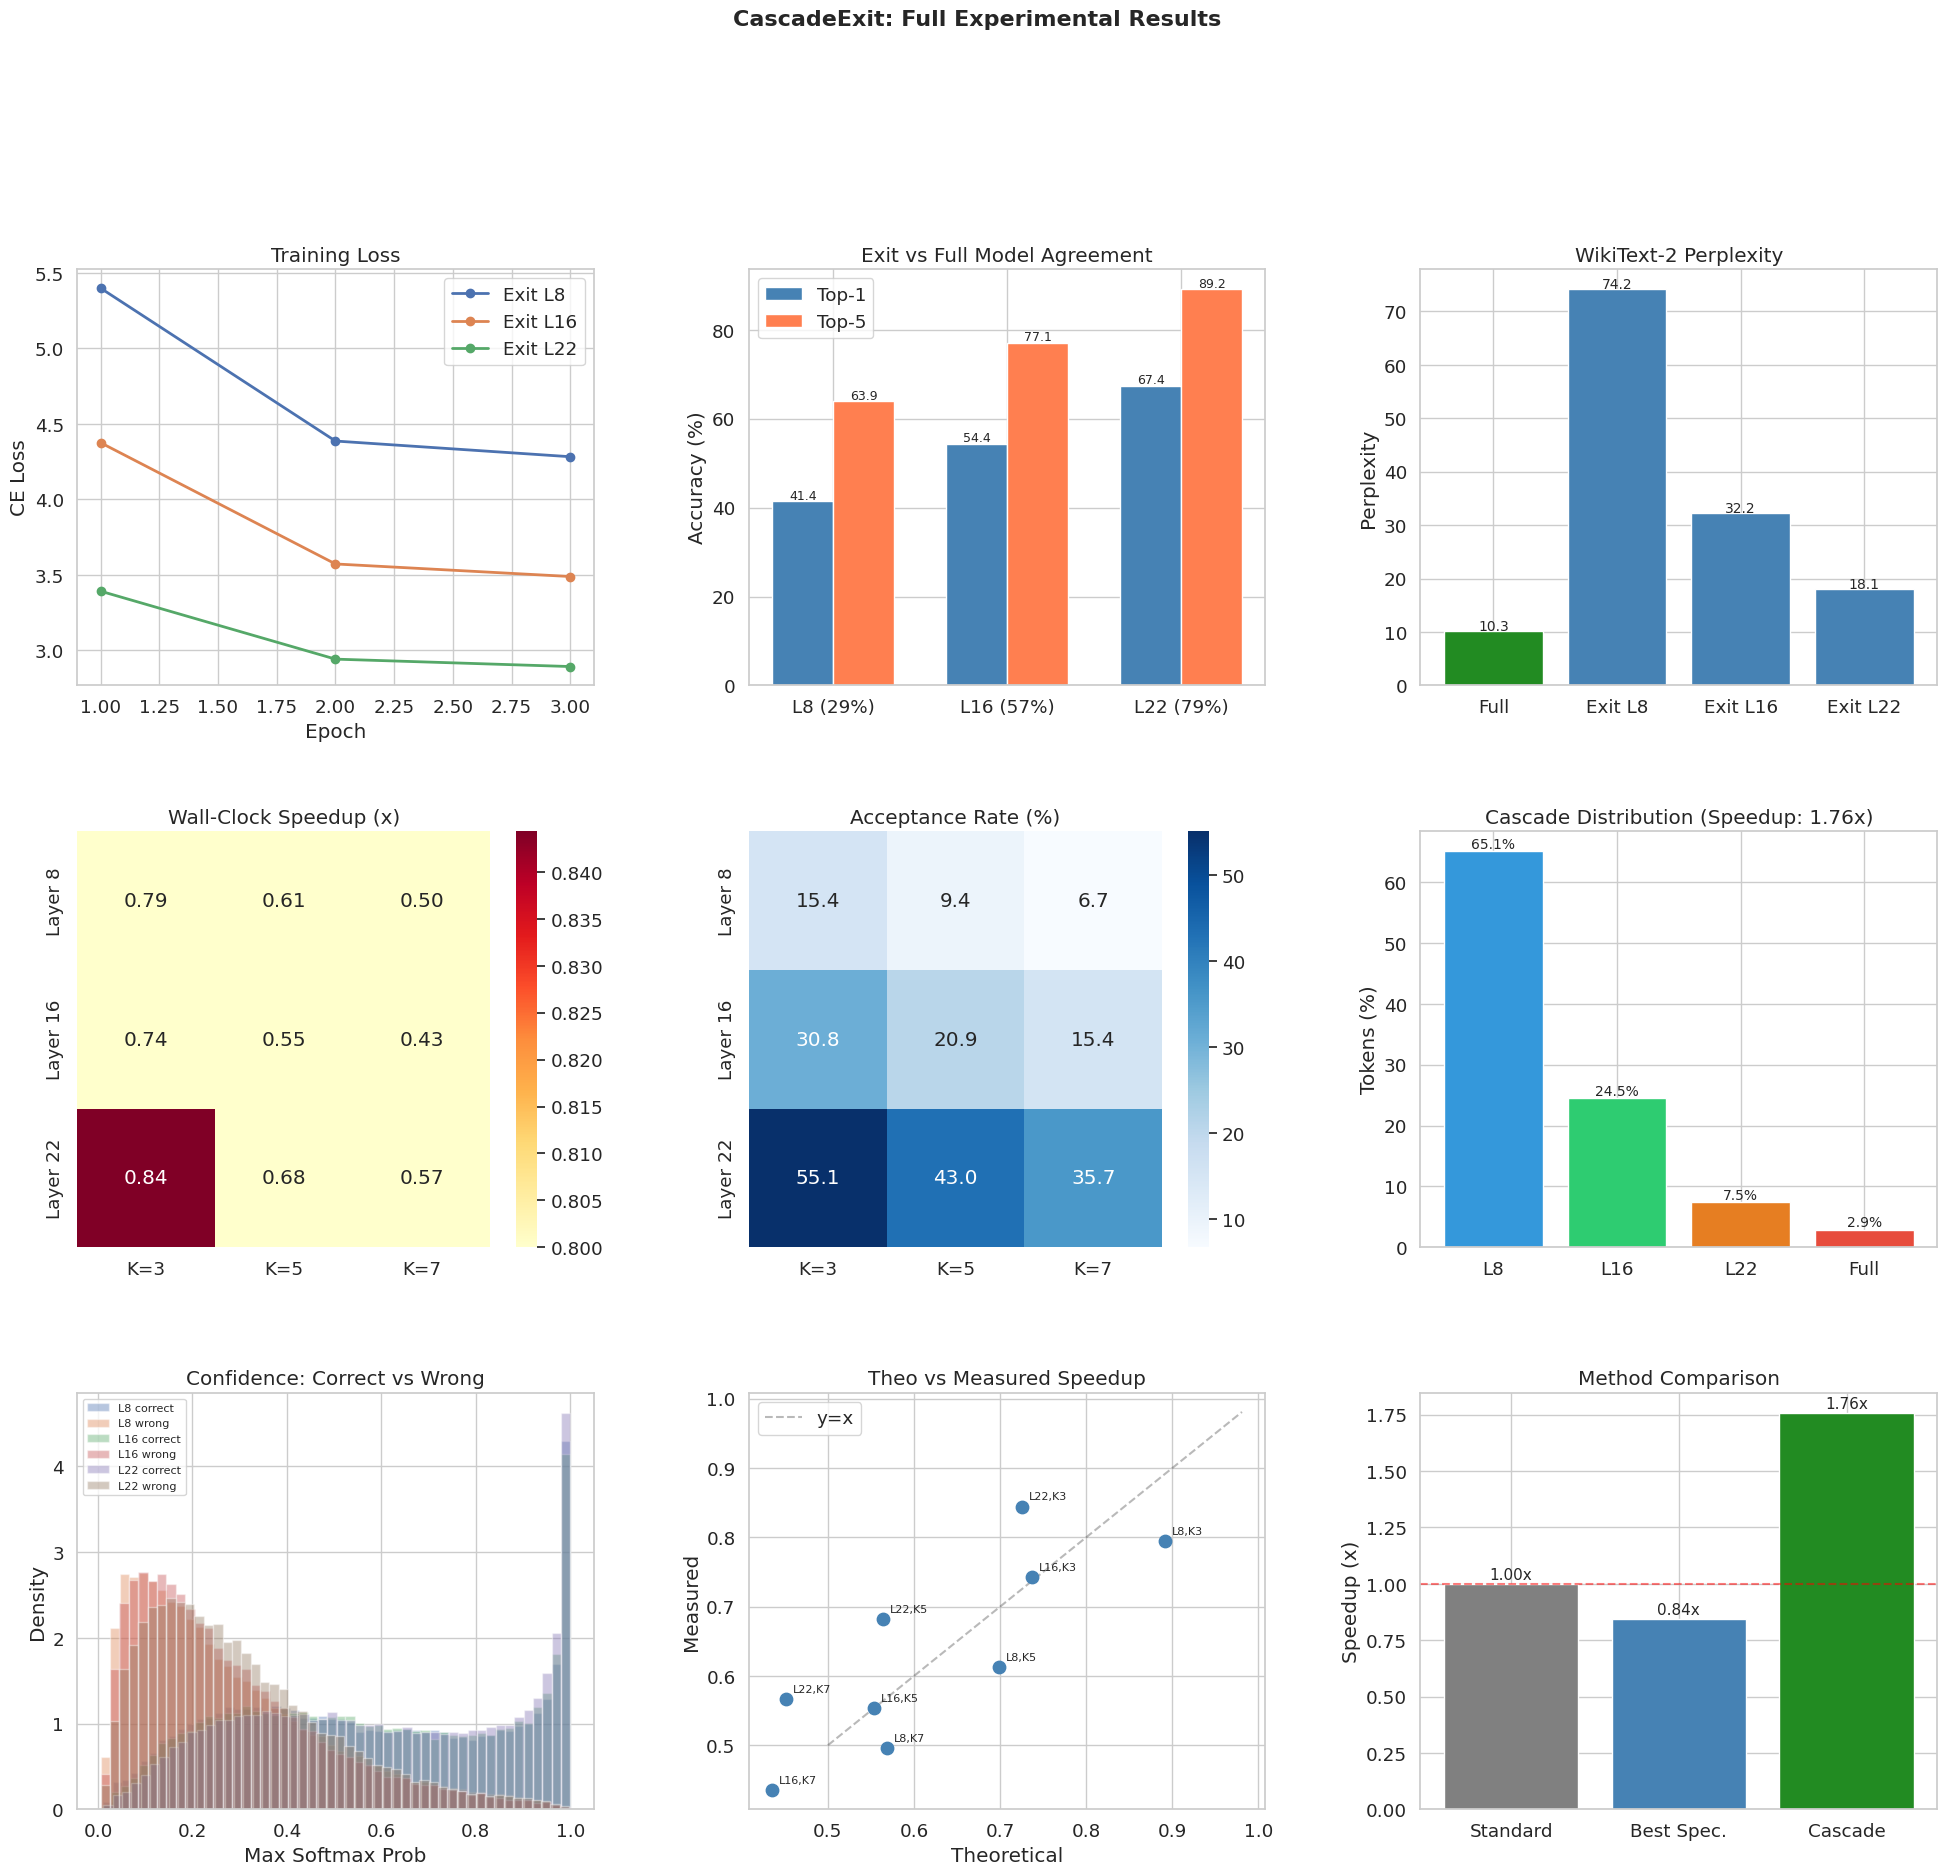

  [phase8_visualization] complete
Figures saved. Phase 8 complete in 7s


In [23]:
#@title Phase 8: Comprehensive Visualization
print('='*70)
print('PHASE 8: Visualization')
print('='*70)

phase8_start = time.time()
sns.set_theme(style='whitegrid', font_scale=1.2)

fig = plt.figure(figsize=(24, 20))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# 1) Training Loss
ax1 = fig.add_subplot(gs[0, 0])
for layer_idx in CONFIG['exit_layers']:
    ces = [log[f'L{layer_idx}_ce'] for log in train_log]
    ax1.plot(range(1, len(ces)+1), ces, 'o-', label=f'Exit L{layer_idx}', linewidth=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('CE Loss'); ax1.set_title('Training Loss'); ax1.legend()

# 2) Token Accuracy
ax2 = fig.add_subplot(gs[0, 1])
layers = CONFIG['exit_layers']
top1s = [eval_results[l]['top1_accuracy'] * 100 for l in layers]
top5s = [eval_results[l]['top5_accuracy'] * 100 for l in layers]
x = np.arange(len(layers)); width = 0.35
ax2.bar(x - width/2, top1s, width, label='Top-1', color='steelblue')
ax2.bar(x + width/2, top5s, width, label='Top-5', color='coral')
ax2.set_xticks(x); ax2.set_xticklabels([f'L{l} ({l/CONFIG["num_layers"]*100:.0f}%)' for l in layers])
ax2.set_ylabel('Accuracy (%)'); ax2.set_title('Exit vs Full Model Agreement'); ax2.legend()
for i, (t1, t5) in enumerate(zip(top1s, top5s)):
    ax2.text(i - width/2, t1 + 0.5, f'{t1:.1f}', ha='center', fontsize=9)
    ax2.text(i + width/2, t5 + 0.5, f'{t5:.1f}', ha='center', fontsize=9)

# 3) Perplexity
ax3 = fig.add_subplot(gs[0, 2])
ppl_labels = ['Full'] + [f'Exit L{l}' for l in layers]
ppl_vals = [ppl_summary['full_model']['perplexity']] + [ppl_summary[f'exit_{l}']['perplexity'] for l in layers]
colors = ['forestgreen'] + ['steelblue'] * len(layers)
bars = ax3.bar(ppl_labels, ppl_vals, color=colors)
ax3.set_ylabel('Perplexity'); ax3.set_title('WikiText-2 Perplexity')
for bar, val in zip(bars, ppl_vals):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.1f}', ha='center', fontsize=10)

# 4) Speedup Heatmap
ax4 = fig.add_subplot(gs[1, 0])
speedup_matrix = []
for layer_idx in layers:
    row = [speed_summary.get(f'spec_L{layer_idx}_K{K}', {}).get('speedup', 1.0) for K in CONFIG['draft_lengths']]
    speedup_matrix.append(row)
sns.heatmap(np.array(speedup_matrix), annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[f'K={K}' for K in CONFIG['draft_lengths']],
            yticklabels=[f'Layer {l}' for l in layers], ax=ax4, vmin=0.8)
ax4.set_title('Wall-Clock Speedup (x)')

# 5) Acceptance Rate Heatmap
ax5 = fig.add_subplot(gs[1, 1])
acc_matrix = []
for layer_idx in layers:
    row = [speed_summary.get(f'spec_L{layer_idx}_K{K}', {}).get('acceptance_rate', 0) * 100 for K in CONFIG['draft_lengths']]
    acc_matrix.append(row)
sns.heatmap(np.array(acc_matrix), annot=True, fmt='.1f', cmap='Blues',
            xticklabels=[f'K={K}' for K in CONFIG['draft_lengths']],
            yticklabels=[f'Layer {l}' for l in layers], ax=ax5)
ax5.set_title('Acceptance Rate (%)')

# 6) Cascade Exit Distribution
ax6 = fig.add_subplot(gs[1, 2])
sorted_exit_keys = sorted(total_exits.keys(), key=lambda x: int(x) if x != 'full' else 999)
cas_labels = [f'L{k}' if k != 'full' else 'Full' for k in sorted_exit_keys]
cas_vals = [total_exits[k] / max(1, total_all) * 100 for k in sorted_exit_keys]
colors_cas = ['#3498db', '#2ecc71', '#e67e22', '#e74c3c'][:len(cas_labels)]
bars = ax6.bar(cas_labels, cas_vals, color=colors_cas)
ax6.set_ylabel('Tokens (%)'); ax6.set_title(f'Cascade Distribution (Speedup: {cas_speedup:.2f}x)')
for bar, pct in zip(bars, cas_vals):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{pct:.1f}%', ha='center', fontsize=10)

# 7) Confidence Distribution
ax7 = fig.add_subplot(gs[2, 0])
for layer_idx in layers:
    cc = eval_metrics[layer_idx]['confidences_correct']
    cw = eval_metrics[layer_idx]['confidences_wrong']
    if cc: ax7.hist(cc, bins=50, alpha=0.4, label=f'L{layer_idx} correct', density=True)
    if cw: ax7.hist(cw, bins=50, alpha=0.4, label=f'L{layer_idx} wrong', density=True)
ax7.set_xlabel('Max Softmax Prob'); ax7.set_ylabel('Density')
ax7.set_title('Confidence: Correct vs Wrong'); ax7.legend(fontsize=8)

# 8) Theoretical vs Measured Speedup
ax8 = fig.add_subplot(gs[2, 1])
theo, meas, lbl = [], [], []
for layer_idx in layers:
    for K in CONFIG['draft_lengths']:
        key = f'spec_L{layer_idx}_K{K}'
        if key in speed_summary and f'speedup_K{K}' in eval_results.get(layer_idx, {}):
            theo.append(eval_results[layer_idx][f'speedup_K{K}'])
            meas.append(speed_summary[key].get('speedup', 1.0))
            lbl.append(f'L{layer_idx},K{K}')
if theo:
    ax8.scatter(theo, meas, s=80, c='steelblue', zorder=5)
    for i, lb in enumerate(lbl): ax8.annotate(lb, (theo[i], meas[i]), fontsize=8, xytext=(5,5), textcoords='offset points')
    mx = max(max(theo), max(meas)) * 1.1
    ax8.plot([0.5, mx], [0.5, mx], 'k--', alpha=0.3, label='y=x')
ax8.set_xlabel('Theoretical'); ax8.set_ylabel('Measured'); ax8.set_title('Theo vs Measured Speedup'); ax8.legend()

# 9) Method Comparison - find best speculative from speed_summary
best_spec_speedup = max(
    (v.get('speedup', 0) for k, v in speed_summary.items()
     if isinstance(v, dict) and k.startswith('spec_')),
    default=1.0
)
methods = ['Standard', 'Best Spec.', 'Cascade']
speedups = [1.0, best_spec_speedup, cas_speedup]
colors_m = ['gray', 'steelblue', 'forestgreen']
bars = ax9 = fig.add_subplot(gs[2, 2])
bars_plot = ax9.bar(methods, speedups, color=colors_m)
ax9.set_ylabel('Speedup (x)'); ax9.set_title('Method Comparison'); ax9.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
for bar, val in zip(bars_plot, speedups):
    ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.2f}x', ha='center', fontsize=11)

plt.suptitle('CascadeExit: Full Experimental Results', fontsize=16, fontweight='bold', y=1.01)
plt.savefig(OUT / 'figures' / 'full_results.png', dpi=150, bbox_inches='tight')
plt.savefig(OUT / 'figures' / 'full_results.pdf', bbox_inches='tight')
plt.show()

phase8_time = time.time() - phase8_start
save_progress('phase8_visualization', 'complete', {'time_seconds': phase8_time})
print(f'Figures saved. Phase 8 complete in {phase8_time:.0f}s')

In [24]:
#@title Phase 9: Final Summary
print('='*70)
print('PHASE 9: Final Summary')
print('='*70)

total_time = time.time() - phase1_start

# Best speculative config
best_spec_key = max(
    [k for k in speed_summary if k.startswith('spec_')],
    key=lambda k: speed_summary[k].get('speedup', 0)
)
best_spec = speed_summary[best_spec_key]

final_summary = {
    'project': 'CascadeExit: Adaptive Early-Exit Speculative Decoding',
    'author': 'Alireza Shojaei',
    'completion_time': datetime.now().isoformat(),
    'total_runtime_hours': total_time / 3600,
    'gpu': torch.cuda.get_device_name(0),
    'base_model': CONFIG['base_model'],
    'base_model_params': total_params,
    'exit_adapter_params': adapter_params + conf_params,
    'parameter_overhead_percent': (adapter_params + conf_params) / total_params * 100,
    'exit_head_accuracy': {f'layer_{l}': eval_results[l]['top1_accuracy'] for l in CONFIG['exit_layers']},
    'exit_head_top5': {f'layer_{l}': eval_results[l]['top5_accuracy'] for l in CONFIG['exit_layers']},
    'perplexity': ppl_summary,
    'best_speculative_config': best_spec_key,
    'best_speculative_speedup': best_spec.get('speedup', 0),
    'best_acceptance_rate': best_spec.get('acceptance_rate', 0),
    'cascade_speedup': cas_speedup,
    'cascade_avg_cost': cas_avg_cost,
    'cascade_exit_distribution': dict(total_exits),
    'quality_match_rate': match_rate,
    'training_config': {
        'train_samples': CONFIG['train_samples'],
        'epochs': CONFIG['train_epochs'],
        'learning_rate': CONFIG['learning_rate'],
        'distill_temperature': CONFIG['distill_temperature'],
    },
}

with open(OUT / 'FINAL_SUMMARY.json', 'w') as f:
    json.dump(final_summary, f, indent=2, default=str)

print(f'Base Model: {CONFIG["base_model"]} ({total_params/1e9:.2f}B params)')
print(f'Exit Adapter Overhead: {total_new:,} params ({total_new/total_params*100:.3f}%)')
print(f'Total Runtime: {total_time/3600:.1f} hours')
print(f'\nExit Head Accuracy (Top-1 vs full model):')
for l in CONFIG['exit_layers']:
    print(f'  Layer {l} ({l/CONFIG["num_layers"]*100:.0f}%): {eval_results[l]["top1_accuracy"]*100:.1f}%')
print(f'\nPerplexity (WikiText-2):')
print(f'  Full model: {ppl_summary["full_model"]["perplexity"]:.2f}')
for l in CONFIG['exit_layers']:
    ppl = ppl_summary[f'exit_{l}']['perplexity']
    diff = (ppl - ppl_summary['full_model']['perplexity']) / ppl_summary['full_model']['perplexity'] * 100
    print(f'  Exit L{l}: {ppl:.2f} (+{diff:.1f}%)')
print(f'\nBest Speculative: {best_spec_key} -> {best_spec.get("speedup", 0):.2f}x speedup')
print(f'Cascade: {cas_speedup:.2f}x speedup (avg cost {cas_avg_cost:.3f}x)')
print(f'Quality: {match_rate:.0f}% identical to full model')
print(f'\nAll results: {OUT}')
print('\n' + '='*70)
print('EXPERIMENT COMPLETE')
print('='*70)

save_progress('phase9_complete', 'complete', {
    'total_runtime_hours': total_time / 3600,
    'best_speedup': best_spec.get('speedup', 0),
    'cascade_speedup': cas_speedup,
})

PHASE 9: Final Summary
Base Model: meta-llama/Llama-3.2-3B (3.21B params)
Exit Adapter Overhead: 16,525,827 params (0.514%)
Total Runtime: 7.0 hours

Exit Head Accuracy (Top-1 vs full model):
  Layer 8 (29%): 41.4%
  Layer 16 (57%): 54.4%
  Layer 22 (79%): 67.4%

Perplexity (WikiText-2):
  Full model: 10.26
  Exit L8: 74.18 (+622.7%)
  Exit L16: 32.25 (+214.2%)
  Exit L22: 18.06 (+76.0%)

Best Speculative: spec_L22_K3 -> 0.84x speedup
Cascade: 1.76x speedup (avg cost 0.414x)
Quality: 20% identical to full model

All results: /content/drive/MyDrive/CascadeExit-Research

EXPERIMENT COMPLETE
  [phase9_complete] complete
